In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from scipy import sparse

In [2]:
#### COLLECTION
########################################################################
#Dữ liệu movie
name_cols = ['movie_id', 'movie_title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies = pd.read_csv('ml-100k/u.item', sep='|', names=name_cols, encoding='latin-1')
movies.head()

,movie_id,movie_title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [3]:
#Dữ liệu rating
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols, encoding='latin-1')

Y_data=ratings.values
ratings.head()
#print(Y_data)

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
##### PREPARE
############################################################################
#Kiểm tra cột unknow
unknown = movies['unknown'].value_counts()
print(unknown)

0    1680
1       2
Name: unknown, dtype: int64


Text(0, 0.5, 'Số lượng ratings')

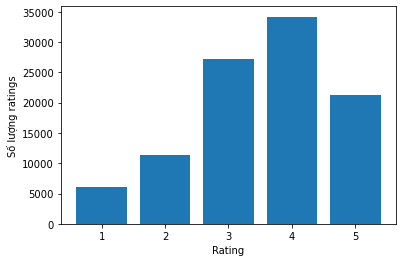

In [5]:
rating_counts = ratings['rating'].value_counts().sort_index()
plt.bar(rating_counts.index, rating_counts.values)

plt.xlabel('Rating')
plt.ylabel('Số lượng ratings')

In [6]:
movies = movies.drop('video release date', axis = 1)
movies = movies.drop('IMDb URL', axis = 1)
movies = movies.drop('release date', axis = 1)
movies = movies.drop('unknown', axis = 1)
ratings = ratings.drop('unix_timestamp', axis = 1)

In [7]:
###### CHOOSE và TRAIN
#Tạo 1 class mang tên CF để huấn luyện model
class CF(object):
    #Hàm khởi tạo các biến
    '''
    Y_data là ma trận gồm 3 cột lần lượt là user_id, movie_id, rating
    k là số điểm lân cận gần nhất mình muốn lấy để train
    dist_func là hàm tính độ tương đồng, ở đây chúng em sử dụng hàm cosine
    uuCF là biến xác định sử dụng theo phương thức gì: 
        user-user thì uuCF = 1
        item-item thì uuCF = 0
    '''
    def __init__(self, Y_data, k, dist_func = cosine_similarity, uuCF=1):
        self.uuCF = uuCF
        self.Y_data = Y_data if uuCF == 1 else Y_data[:, [1, 0, 2]]
        self.k = k
        self.dist_func = dist_func
        self.Ybar_data = None
        
        self.n_users = int(np.max(self.Y_data[:, 0])) + 1 
        self.n_movies = int(np.max(self.Y_data[:, 1])) + 1
        
        
    # Hàm update cho ma trận Y_data nếu như có thêm lượt rating mới
    def add(self, new_data):
        self.Y_data = np.concatenate((self.Y_data, new_data), axis = 0)
       
    
    #Hàm chuẩn hóa ma trận thưa
    def normalize_Y(self):
        users = self.Y_data[:, 0]
        self.Ybar_data = self.Y_data.copy()
        self.mu = np.zeros((self.n_users,))
        for n in range(self.n_users):
            ids = np.where(users == n)[0].astype(np.int32)
            item_ids = self.Y_data[ids, 1] 
            ratings = self.Y_data[ids, 2]
            
            m = np.mean(ratings) 
            if np.isnan(m):
                m = 0 
            # normalize
            self.Ybar_data[ids, 2] = ratings - self.mu[n]
        self.Ybar = sparse.coo_matrix((self.Ybar_data[:, 2],
            (self.Ybar_data[:, 1], self.Ybar_data[:, 0])), (self.n_movies, self.n_users))
        self.Ybar = self.Ybar.tocsr()

    #Hàm tính độ tương đồng
    def similarity(self):
        self.S = self.dist_func(self.Ybar.T, self.Ybar.T)
    
    #Hàm chuẩn hóa lại và tính lại độ tương đồng nếu như có thêm lượt rating mới
    def refresh(self):
        self.normalize_Y()
        self.similarity() 
        
    def fit(self):
        self.refresh()
        
        
    #Hàm dự đoán    
    def __pred(self, u, i, normalized = 1):
        # Step 1: Tìm tất cả người dùng đã rate cho movie i
        ids = np.where(self.Y_data[:, 1] == i)[0].astype(np.int32)
        users_rated_i = (self.Y_data[ids, 0]).astype(np.int32)
        # Step 2: tính độ tương đồng của người dùng muốn biết với những người dùng đã rate movie i
        sim = self.S[u, users_rated_i]
        # Step 4: Cho số k người dùng neigbor
        a = np.argsort(sim)[-self.k:] 
        nearest_s = sim[a]
        r = self.Ybar[i, users_rated_i[a]]
        if normalized:
            return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8)

        return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8) + self.mu[u]
    
    
    def pred(self, u, i, normalized = 1):
        """ 
        Xác định cho hàm là sẽ sử dụng phương thức user-user hay là item-item
        """
        if self.uuCF: return self.__pred(u, i, normalized)
        return self.__pred(i, u, normalized)
    
    def recommend(self, u, normalized = 1):
        """
        Xác định những bộ phim có thể đề xuất cho user (với uuCF = 0)
        Xác định những người dùng có thể sẽ quan tâm đến movie nào đó (với uuCF =)
        """
        ids = np.where(self.Y_data[:, 0] == u)[0]
        movies_rated_by_u = self.Y_data[ids, 1].tolist()              
        recommended_movies = []
        for i in range(self.n_movies):
            if i not in movies_rated_by_u:
                rating = self.__pred(u, i)
                if rating > 0: 
                    recommended_movies.append(i)
        
        return recommended_movies 
    
    
    def recommend_top(self, u, top_x):
        """
        Tìm top 10 bộ phim gần nhất có thể recommend cho một user
        mà những bộ phim đó là những bộ mà user đó chưa từng rating
        """
        ids = np.where(self.Y_data[:, 1] == u)[0]
        items_rated_by_u = self.Y_data[ids, 0].tolist()
        item = {'id': None, 'similar': None}
        list_items = []

        def take_similar(elem):
            return elem['similar']

        for i in range(self.n_movies):
            if i not in items_rated_by_u:
                rating = self.pred(u, i)
                item['id'] = i
                item['similar'] = rating
                list_items.append(item.copy())

        sorted_items = sorted(list_items, key=take_similar, reverse=True)[:top_x]
        return sorted_items


In [8]:
#Chia tập dữ liệu 80 train, 20 test
train_data, test_data = train_test_split(Y_data, test_size=0.2, random_state=0)

In [9]:

rs_user = CF(train_data, k = 30, uuCF = 1)
rs_user.fit()

n_tests = test_data.shape[0]
SE = 0 # squared error
for n in range(n_tests):
    pred = rs_user.pred(test_data[n, 0], test_data[n, 1], normalized = 0)
    SE += (pred - test_data[n, 2])**2 

RMSE = np.sqrt(SE/n_tests)
print('User-user CF, RMSE =', RMSE)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


User-user CF, RMSE = 1.024783532828137


In [11]:
rs_item = CF(train_data, k = 30, uuCF = 0)
rs_item.fit()

n_tests = test_data.shape[0]
SE = 0 # squared error
for n in range(n_tests):
    pred = rs_item.pred(test_data[n, 0], test_data[n, 1], normalized = 0)
    SE += (pred - test_data[n, 2])**2 

RMSE = np.sqrt(SE/n_tests)
print ('Item-item CF, RMSE =', RMSE)

Item-item CF, RMSE = 0.9840957127910445


In [12]:
user_id_to_recommend = 400  # Đổi giá trị này thành ID người dùng bạn muốn đề xuất
top_recommendations = rs_item.recommend_top(user_id_to_recommend, top_x=10)

# Lấy danh sách các item được đề xuất
recommended_item_ids = [item['id'] for item in top_recommendations]

# In thông tin về các bộ phim được đề xuất
recommended_movies_info = movies[movies['movie_id'].isin(recommended_item_ids)]
print('Có thể bạn sẽ thích những bộ phim này đấy: ',recommended_movies_info[['movie_title']])

Có thể bạn sẽ thích những bộ phim này đấy:                                  movie_title
17                White Balloon, The (1995)
118  Maya Lin: A Strong Clear Vision (1994)
295                     Promesse, La (1996)
438     Amityville: A New Generation (1993)
642                     The Innocent (1994)
756           Across the Sea of Time (1995)
776                     Castle Freak (1995)
787                    Relative Fear (1994)
834                Gay Divorcee, The (1934)
919                         Two Bits (1995)
